# Convolutional autoencoders

In this script we write a CNN autoencoder and apply it to the task of image desnoising.

In [16]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import copy

# Define the data repository
data_dir = 'data/'

In [17]:
# Initialization function
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)
    return

## Transposed convolution

As seen in the previous lab, convolution usually reduces the size of the image. However, in some applications (e.g., image synthesis from low-dimension features) it is usefull to increase it. That's notably needed for autoencoders, since after projecting the data into a compact latent representation, we need to expand this representation back into the image space.

This is exactly what [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html#torch.nn.ConvTranspose2d) does. Simply put, a transposed convolution adds some zeros inside the input image (and on the edge) to artificially increase the size.

Convolution             |  Transposed convolution
:-------------------------:|:-------------------------:
![](https://miro.medium.com/max/294/1*BMngs93_rm2_BpJFH2mS0Q.gif)  |  ![](https://miro.medium.com/max/395/1*Lpn4nag_KRMfGkx1k6bV-g.gif)

<center><a href="https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d">Source</a></center>

On the left, we use convolution with a kernel size of 3 and stride of 2. On the right, we then use a transpoed convolution with the same parameters, and its effect is to procude an image with the same size as the original.

(343, 550)


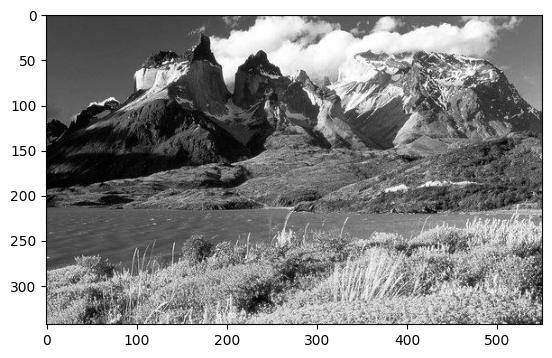

In [18]:
# Load the provided example image as black and white, and normalize it so the values ranges in [0, 1]
image_np = io.imread('tdp.jpeg', as_gray=True)
print(image_np.shape)
image_np = image_np / np.max(image_np)

# Display the image
plt.imshow(image_np, cmap='gray')
plt.show()

# Convert the image into a pytorch float tensor (and unsqueeze it to the proper size)
image_t = torch.tensor(image_np).float().unsqueeze(0).unsqueeze(0)

Original image:  torch.Size([1, 1, 343, 550])
Output of the convolution :  torch.Size([1, 1, 86, 137])


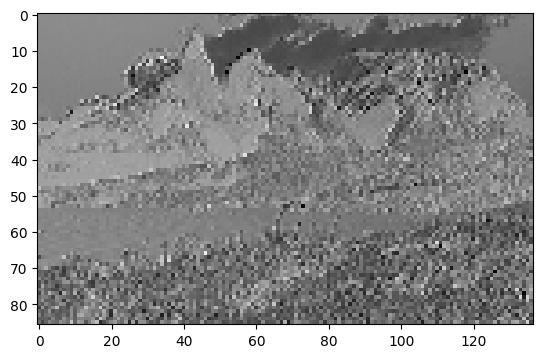

In [19]:
num_channels_in = 1
num_channels_out = 1

# First, let us apply a convolution with a kernel size of (3, 6) and a stride of 4.
my_conv = nn.Conv2d(num_channels_in, num_channels_out, kernel_size=(3, 6), stride=4, bias=False)
output = my_conv(image_t)
print('Original image: ', image_t.shape)
print('Output of the convolution : ', output.shape)

# Display the output after convolution
plt.imshow(output.detach().squeeze(), cmap='gray')
plt.show()

After applying transposed convolution :  torch.Size([1, 1, 343, 550])


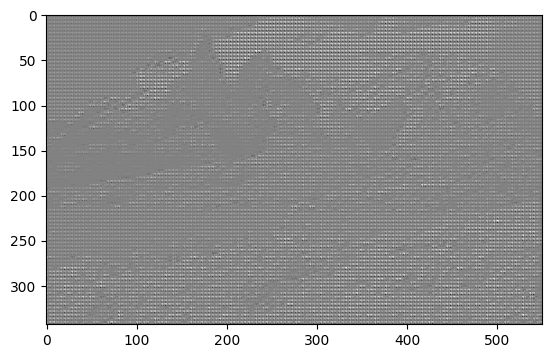

In [20]:
# Now we reproduce an image with the same size as the original input
my_convt = nn.ConvTranspose2d(num_channels_in, num_channels_out, kernel_size=(3, 6), stride=4, bias=False)
image_convt = my_convt(output)
print('After applying transposed convolution : ', image_convt.shape)

# Display the output after transposed convolution
plt.imshow(image_convt.detach().squeeze(), cmap='gray')
plt.show()

As you can see, transposed convolution does not invert convolution (it's not "deconvolution"): it only guarantees that the size will be equal to that of the image before convolution (but not its pixel values).

## Dataset

In [21]:
# Load the MNIST dataset
train_data = datasets.MNIST(data_dir, train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor())
num_classes = len(train_data.classes)

# Take a subset of the train/test data
train_data = Subset(train_data, torch.arange(400))
test_data = Subset(test_data, torch.arange(50))

# Create dataloaders
batch_size = 8
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

## CNN autoencoder

As we saw it in lab 4, autoencoders are networks that project the input data into a low-dimension space, and then expand this compact representation back into the input space. In CNN autoencoders, the encoder uses convolutions to reduce the image size, while the decoder uses transposed convolutions to expand it. We propose the following architecture:

- The encoder consists of two layers, with a convolution function, a RELU and a max pooling. The convolution functions have a kernel size of 3 and a padding of 1. They use 16 and 4 output channels, respectively. The max pooling functions use a kernel size of 2.

- The decoder consists of two layers, with a transpoed convolution function and a RELU and a Tanh activation, respectively. The transposed convolution functions have a kernel size of 2 and a stride of 2. They use 16 and 1 output channels, respectively.

In [22]:
# TO DO: write the CNN autoencoder module ('__init__' and 'forward' methods)

class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Conv2d(1, 16, kernel_size=3, padding=1),
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=2),
                                      nn.Conv2d(16, 4, kernel_size=3, padding=1),
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=2))
        self.decoder = nn.Sequential(nn.ConvTranspose2d(4, 16, kernel_size=2, stride=2),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
                                     nn.ReLU())
    
    def forward(self, x):
        x = self.encoder(x)
        y = self.decoder(x)
        y = nn.Tanh()(y)
        return y

In [23]:
# Instantiate the CNN autoencoder, initialize it and print the number of parameters
model_cnn_ae = CNNAutoencoder()
torch.manual_seed(0)
model_cnn_ae.apply(init_weights)
print('Total number of parameters:', sum(p.numel() for p in model_cnn_ae.parameters()))

Total number of parameters: 1077


<span style="color:red">**Q3**</span> How many parameters are in the model?

In [24]:
# TO DO: write the training function.
# It's similar to the MLP autoencoder (lab 4 - uses the ADAM optimizer), but images don't need to be vectorized


In [25]:
# TO DO: write the training function (you can reuse the code from lab 3 or 4.1)
def training_ae(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):
 
   # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    
    # Define the optimizer
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    #val_accuracy = []
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, _) in enumerate(train_dataloader):
            
            # TO DO: write the training procedure for each batch. This should consist of:
            # - vectorizing the images (size should be (batch_size, input_size))
            # - apply the forward pass (calculate the predicted labels from the vectorized images)
            # - use the 'backward' method to compute the gradients
            # - apply the gradient descent algorithm
            # Also think of updating the loss at the current epoch
            y_pred = model_tr(images)
            l = loss_fn(y_pred, images)
            optimizer.zero_grad()
            l.backward()
            loss_current_epoch += l.item()
            optimizer.step() #update parameters

        # At the end of each epoch, record and display the loss over all batches
        loss_all_epochs.append(loss_current_epoch)
        #accuracy = eval_mlp_classifier(model_tr, eval_dataloader)
        #val_accuracy.append(accuracy)
        if verbose:
            print('Epoch [{}/{}], Loss: {:.4f},'.format(epoch+1, num_epochs, loss_current_epoch))
        
    return model_tr, loss_all_epochs

In [26]:
# TO DO:
# - define the optimize parameters: 200 epochs, MSE loss function, learning_rate=0.001
# - train the model
loss_fn = nn.MSELoss()
num_epochs = 200
lr = 0.001
model_cnn_ae, history = training_ae(model_cnn_ae, train_dataloader, num_epochs, loss_fn, lr, verbose=True)

Epoch [1/200], Loss: 4.8406,
Epoch [2/200], Loss: 3.5631,
Epoch [3/200], Loss: 2.9260,
Epoch [4/200], Loss: 2.2907,
Epoch [5/200], Loss: 2.0461,
Epoch [6/200], Loss: 1.8864,
Epoch [7/200], Loss: 1.7796,
Epoch [8/200], Loss: 1.6969,
Epoch [9/200], Loss: 1.6322,
Epoch [10/200], Loss: 1.5814,
Epoch [11/200], Loss: 1.5397,
Epoch [12/200], Loss: 1.5049,
Epoch [13/200], Loss: 1.4747,
Epoch [14/200], Loss: 1.4540,
Epoch [15/200], Loss: 1.4301,
Epoch [16/200], Loss: 1.4093,
Epoch [17/200], Loss: 1.3936,
Epoch [18/200], Loss: 1.3777,
Epoch [19/200], Loss: 1.3628,
Epoch [20/200], Loss: 1.3485,
Epoch [21/200], Loss: 1.3363,
Epoch [22/200], Loss: 1.3232,
Epoch [23/200], Loss: 1.3139,
Epoch [24/200], Loss: 1.3060,
Epoch [25/200], Loss: 1.3001,
Epoch [26/200], Loss: 1.2936,
Epoch [27/200], Loss: 1.2866,
Epoch [28/200], Loss: 1.2800,
Epoch [29/200], Loss: 1.2747,
Epoch [30/200], Loss: 1.2679,
Epoch [31/200], Loss: 1.2643,
Epoch [32/200], Loss: 1.2624,
Epoch [33/200], Loss: 1.2590,
Epoch [34/200], Los

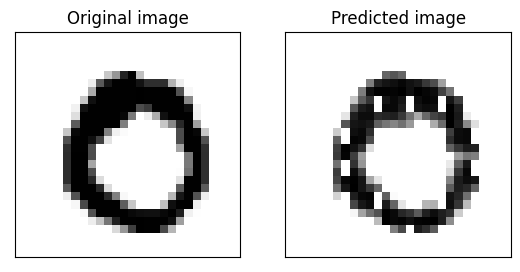

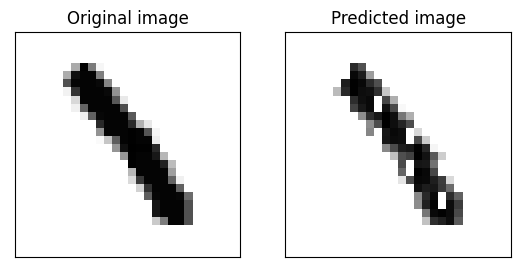

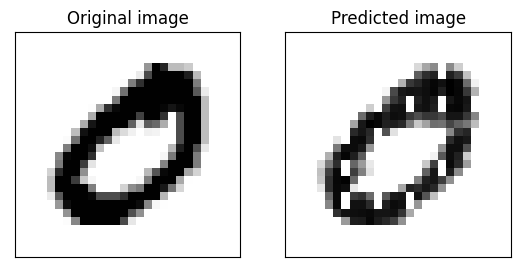

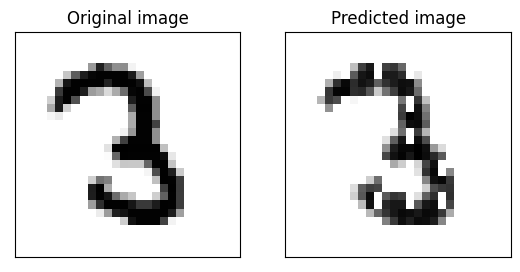

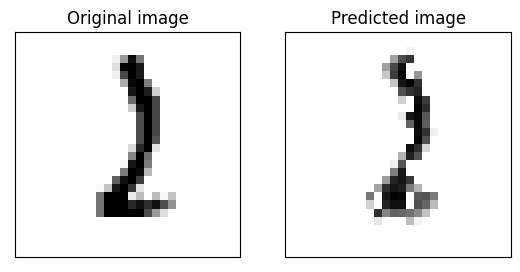

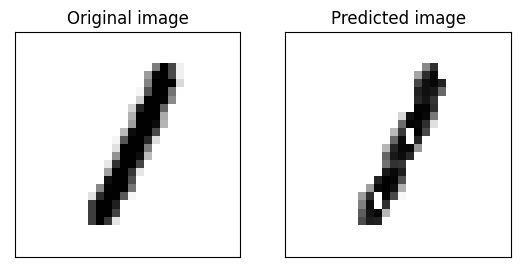

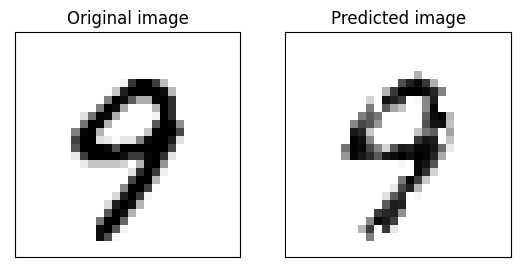

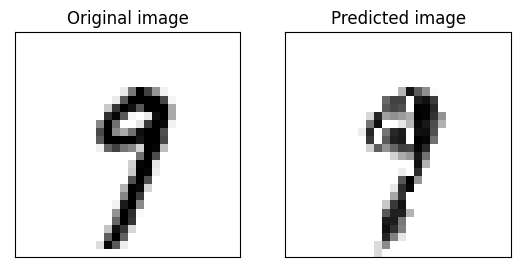

In [27]:
# Vizualization: apply the autoencoder to a batch of images

# Load it
image_batch_example = next(iter(train_dataloader))[0]

# Pass it to the autoencoder 
predicted_batch_example = model_cnn_ae(image_batch_example).detach()

# Plot the original and predicted images
for ib in range(batch_size):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Original image')
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Predicted image')
    plt.show()

<span style="color:red">**Q4**</span> Put one of the plots above in your report.

## Denoising autoencoder (bonus)

We now consider an application of autoencoders, which is image denoising. For this task, we can use the same CNN autoencoder model as before: the only thing that changes is the data on which it is trained.

<center><a href="https://en.wikipedia.org/wiki/Total_variation_denoising">
    <img src="https://upload.wikimedia.org/wikipedia/en/e/e8/ROF_Denoising_Example.png"></a></center>


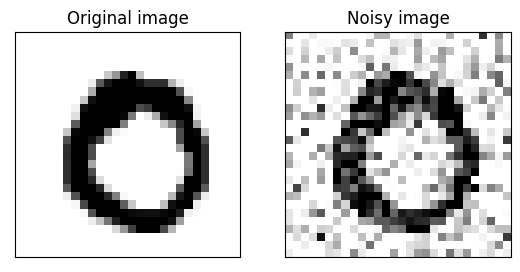

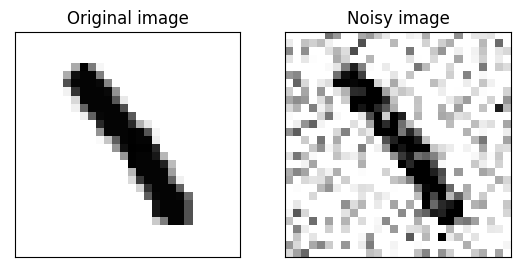

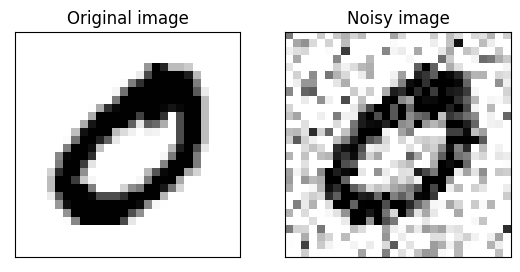

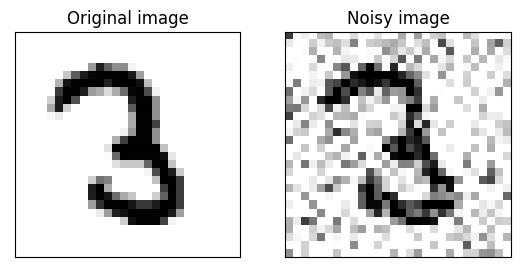

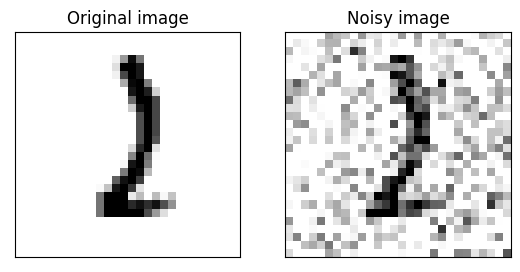

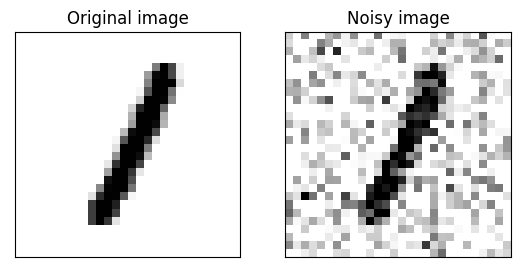

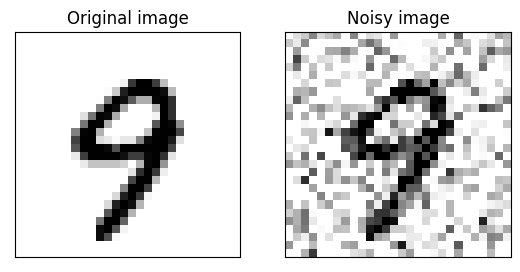

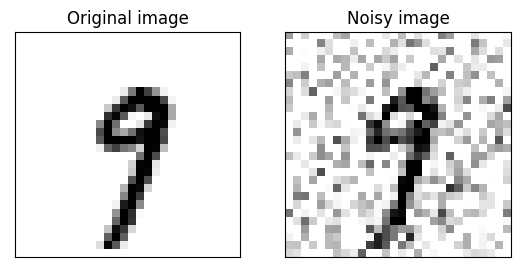

In [28]:
# First, here is a function that adds some noise to an input image batch
def add_noise(inputs,noise_factor=0.3):
     noisy = inputs+torch.randn_like(inputs) * noise_factor
     noisy = torch.clip(noisy,0.,1.)
     return noisy

# Add noise to the image_batch_example
noisy_images_batch = add_noise(image_batch_example)

# Plot the original and noisy images
for ib in range(batch_size):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Original image')
    plt.subplot(1, 2, 2)
    plt.imshow(noisy_images_batch[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Noisy image')
    plt.show()

Since we don't want to create a new dataset, we will simply add noise to the images during training. Therefore, the training function should be the same as before, except we add noise to the images between passing them to the model. Then, we compute the loss between the (true) clean images and the output of the model.

In [32]:
# TO DO: write the training function for the denoising autoencoder
def training_ae(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):
 
   # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    
    # Define the optimizer
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    #val_accuracy = []
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, _) in enumerate(train_dataloader):
            
            # TO DO: write the training procedure for each batch. This should consist of:
            # - vectorizing the images (size should be (batch_size, input_size))
            # - apply the forward pass (calculate the predicted labels from the vectorized images)
            # - use the 'backward' method to compute the gradients
            # - apply the gradient descent algorithm
            # Also think of updating the loss at the current epoch
            y_pred = model_tr(add_noise(images))
            l = loss_fn(y_pred, images)
            optimizer.zero_grad()
            l.backward()
            loss_current_epoch += l.item()
            optimizer.step() #update parameters

        # At the end of each epoch, record and display the loss over all batches
        loss_all_epochs.append(loss_current_epoch)
        #accuracy = eval_mlp_classifier(model_tr, eval_dataloader)
        #val_accuracy.append(accuracy)
        if verbose:
            print('Epoch [{}/{}], Loss: {:.4f},'.format(epoch+1, num_epochs, loss_current_epoch))
        
    return model_tr, loss_all_epochs

In [33]:
# TO DO:
# - instantiate and initialize a CNN autoencoder model
# - define the traing parameters: 200 epochs, MSE loss function, learning_rate=0.001
# - train the model
model_cnn_ae = CNNAutoencoder()
torch.manual_seed(0)
model_cnn_ae.apply(init_weights)
model_cnn_ae, history = training_ae(model_cnn_ae, train_dataloader, num_epochs, loss_fn, lr, verbose=True)

Epoch [1/200], Loss: 6.9361,
Epoch [2/200], Loss: 4.4211,
Epoch [3/200], Loss: 2.5656,
Epoch [4/200], Loss: 2.0203,
Epoch [5/200], Loss: 1.5948,
Epoch [6/200], Loss: 1.3419,
Epoch [7/200], Loss: 1.2238,
Epoch [8/200], Loss: 1.1556,
Epoch [9/200], Loss: 1.1037,
Epoch [10/200], Loss: 1.0774,
Epoch [11/200], Loss: 1.0609,
Epoch [12/200], Loss: 1.0356,
Epoch [13/200], Loss: 1.0168,
Epoch [14/200], Loss: 1.0053,
Epoch [15/200], Loss: 1.0001,
Epoch [16/200], Loss: 0.9873,
Epoch [17/200], Loss: 0.9720,
Epoch [18/200], Loss: 0.9712,
Epoch [19/200], Loss: 0.9689,
Epoch [20/200], Loss: 0.9589,
Epoch [21/200], Loss: 0.9536,
Epoch [22/200], Loss: 0.9501,
Epoch [23/200], Loss: 0.9449,
Epoch [24/200], Loss: 0.9388,
Epoch [25/200], Loss: 0.9420,
Epoch [26/200], Loss: 0.9397,
Epoch [27/200], Loss: 0.9294,
Epoch [28/200], Loss: 0.9258,
Epoch [29/200], Loss: 0.9355,
Epoch [30/200], Loss: 0.9317,
Epoch [31/200], Loss: 0.9237,
Epoch [32/200], Loss: 0.9195,
Epoch [33/200], Loss: 0.9152,
Epoch [34/200], Los

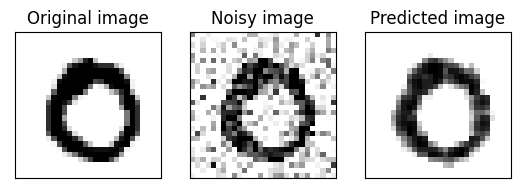

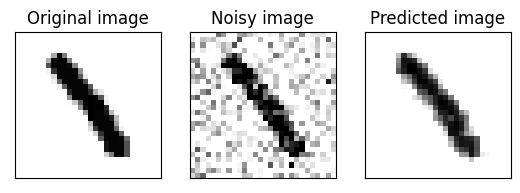

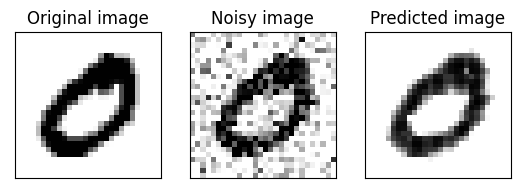

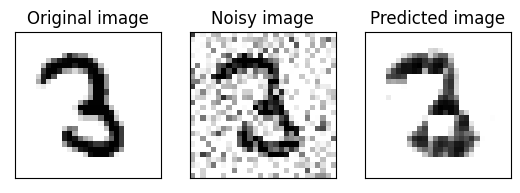

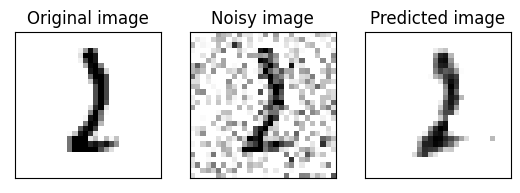

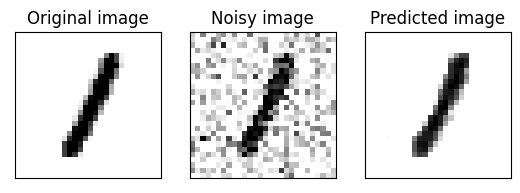

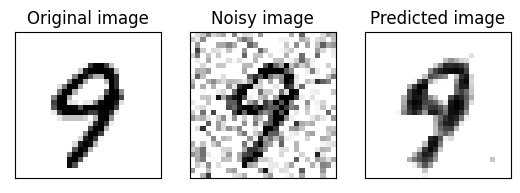

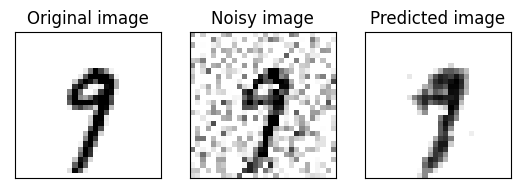

In [34]:
# Vizualization: apply the denoising autoencoder to a batch of noisy images

# Pass it to the autoencoder 
predicted_batch_example = model_cnn_ae(noisy_images_batch).detach()

# Plot the original and predicted images
for ib in range(batch_size):
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(image_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Original image')
    plt.subplot(1, 3, 2)
    plt.imshow(noisy_images_batch[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Noisy image')
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Predicted image')
    plt.show()

<span style="color:red">**Q5**</span> Put one of the plots above in your report. What's the effect of the denoising autoencoder?